# Mining the Web of HTML-embedded Product Data

- https://ir-ischool-uos.github.io/mwpd/index.html
- https://github.com/huggingface/transformers#quick-tour-of-the-fine-tuningusage-scripts

In [ ]:
%%bash
if [ ! -d "data" ]; then mkdir data; fi

cd data
wget http://data.dws.informatik.uni-mannheim.de/largescaleproductcorpus/data/swc/offers_corpus_english_v2_swc.json.gz
wget http://data.dws.informatik.uni-mannheim.de/largescaleproductcorpus/data/swc/computers_train_xlarge.json.gz
wget http://data.dws.informatik.uni-mannheim.de/largescaleproductcorpus/data/swc/computers_validation.json.gz
# wget http://ge.tt/4JbSC443/v/0

gunzip *.json.gz

In [ ]:
import io
import json
import logging
import os
import pickle
import random

import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import torch
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    DistributedSampler,
    SequentialSampler,
    TensorDataset,
)
from torch.utils.data.sampler import WeightedRandomSampler

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

from transformers.data.processors.utils import (
    DataProcessor,
    InputExample,
    InputFeatures,
)
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

from tqdm import tqdm, trange
tqdm.pandas()

In [ ]:
logger = logging.getLogger(__name__)

In [ ]:
logging.basicConfig(level=logging.INFO)

### Utils

In [ ]:
def set_seed(seed=42, n_gpu=1):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed()

### Sample handling

In [ ]:
class MWPDProdSimProcessor(DataProcessor):
    def _get_data(self, fn_jsonlines):
        df = pd.read_json(fn_jsonlines, lines=True)

        df = self._make_texts_columns(df)

        X = df[["text_left", "text_right"]]
        y = df[["label"]]

        X = X.to_numpy()
        y = y.to_numpy().flatten()

        return X, y
    
    def _make_texts_columns(self, df):
        def _make_text(row):
            row["text_left"] = " ".join([
                row["title_left"] or "",
                row["description_left"] or "",
                row["specTableContent_left"] or "",
            ]).strip()
            row["text_right"] = " ".join([
                row["title_right"] or "",
                row["description_right"] or "",
                row["specTableContent_right"] or "",
            ]).strip()
            return row

        df = df.progress_apply(_make_text, axis=1)
        return df
    
    def _get_train_filename(self, data_dir):
        return os.path.join(data_dir, "train.json")
    
    def _get_dev_filename(self, data_dir):
        return os.path.join(data_dir, "dev.json")

    def get_train_examples(self, data_dir):
        return self._create_examples(
            *self._get_data(self._get_train_filename(data_dir)), "train"
        )

    def get_dev_examples(self, data_dir):
        return self._create_examples(
            *self._get_data(self._get_dev_filename(data_dir)), "dev"
        )

    def get_labels(self):
        raise NotImplementedError()

    def _create_examples(self, X, y, set_type):
        raise NotImplementedError()


class BinaryProcessor(MWPDProdSimProcessor):
    def get_labels(self):
        return [0, 1]

    def _create_examples(self, X, y, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, ((text_a, text_b), label)) in enumerate(zip(X, y)):
            #if i == 0:
            #    continue
            guid = f"{set_type}-{i}"
            # label = (label > 3).astype("int32").astype("str")
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label)
            )
        return examples


class BinaryRegressionProcessor(MWPDProdSimProcessor):
    def get_labels(self):
        return [None]

    def _create_examples(self, X, y, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, ((text_a, text_b), label)) in enumerate(zip(X, y)):
            #if i == 0:
            #    continue
            guid = f"{set_type}-{i}"
            # label = (label > 3).astype("int32").astype("str")
            label = label.astype("float32")
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label)
            )
        return examples

In [ ]:
class BinaryTitleProcessor(BinaryProcessor):
    def get_labels(self):
        return [0, 1]

    def _make_texts_columns(self, df):
        def _make_text(row):
            row["text_left"] = row["title_left"]
            row["text_right"] = row["title_right"]
            row["text_ok"] = bool(row["text_left"]) and bool(row["text_right"])
            return row

        df = df.progress_apply(_make_text, axis=1)

        print(len(df.to_numpy()))
        df = df[df["text_ok"] == True]
        print(len(df.to_numpy()))

        return df


class BinaryDescriptionProcessor(BinaryProcessor):
    def get_labels(self):
        return [0, 1]

    def _make_texts_columns(self, df):
        def _make_text(row):
            row["text_left"] = row["description_left"]
            row["text_right"] = row["description_right"]
            row["text_ok"] = bool(row["text_left"]) and bool(row["text_right"])
            return row

        df = df.progress_apply(_make_text, axis=1)

        print(len(df.to_numpy()))
        df = df[df["text_ok"] == True]
        print(len(df.to_numpy()))

        return df


class BinarySpecTableContentProcessor(BinaryProcessor):
    def get_labels(self):
        return [0, 1]

    def _make_texts_columns(self, df):
        def _make_text(row):
            row["text_left"] = row["specTableContent_left"]
            row["text_right"] = row["specTableContent_right"]
            row["text_ok"] = bool(row["text_left"]) and bool(row["text_right"])
            return row

        df = df.progress_apply(_make_text, axis=1)

        print(len(df.to_numpy()))
        df = df[df["text_ok"] == True]
        print(len(df.to_numpy()))

        return df


class BinaryDescTitleSpecContentProcessor(BinaryProcessor):
    def get_labels(self):
        return [0, 1]

    def _make_texts_columns(self, df):
        def _make_text(row):
            row["text_left"] = " ".join([
                row["description_left"] or "",
                row["title_left"] or "",
                row["specTableContent_left"] or "",
            ]).strip()
            row["text_right"] = " ".join([
                row["description_right"] or "",
                row["title_right"] or "",
                row["specTableContent_right"] or "",
            ]).strip()
            return row

        df = df.progress_apply(_make_text, axis=1)

        return df

In [ ]:
class MWPDAllBinaryProcessor(BinaryProcessor):
    def get_train_examples(self, data_dir):
        return self._create_examples(
            *self._get_data(os.path.join(data_dir, "train_all.json")), "train"
        )

    def get_dev_examples(self, data_dir):
        return self._create_examples(
            *self._get_data(os.path.join(data_dir, "dev_all.json")), "dev"
        )


class MWPDAllBinaryRegressionProcessor(BinaryRegressionProcessor):
    def get_train_examples(self, data_dir):
        return self._create_examples(
            *self._get_data(os.path.join(data_dir, "train_all.json")), "train"
        )

    def get_dev_examples(self, data_dir):
        return self._create_examples(
            *self._get_data(os.path.join(data_dir, "dev_all.json")), "dev"
        )

In [ ]:
processors = {
    "mwpd-b": BinaryProcessor,
    "mwpd-r": BinaryRegressionProcessor,
    "mwpd-title-b": BinaryTitleProcessor,
    "mwpd-desc-b": BinaryDescriptionProcessor,
    "mwpd-spec-b": BinarySpecTableContentProcessor,
    "mwpd-dts-combi-b": BinaryDescTitleSpecContentProcessor,
    "mwpd-all-b": MWPDAllBinaryProcessor,
    "mwpd-all-r": MWPDAllBinaryRegressionProcessor,
}

output_modes = {
    "mwpd-b": "classification",
    "mwpd-title-b": "classification",
    "mwpd-desc-b": "classification",
    "mwpd-spec-b": "classification",
    "mwpd-dts-combi-b": "classification",
    "mwpd-all-b": "classification",
    "mwpd-r": "regression",
    "mwpd-all-r": "regression",
}

### Samples to Features/Inputs

In [ ]:
def convert_examples_to_features(
    examples,
    tokenizer,
    max_length=512,
    task=None,
    label_list=None,
    output_mode=None,
    pad_on_left=False,
    pad_token=0,
    pad_token_segment_id=0,
    mask_padding_with_zero=True,
):
    """
    Loads a data file into a list of ``InputFeatures``
    Args:
        examples: List of ``InputExamples`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum example length
        task: MWPD product similarity task
        label_list: List of labels. Can be obtained from the processor using the ``processor.get_labels()`` method
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0, but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1`` for actual values
            and by ``0`` for padded values. If set to ``False``, inverts it (``1`` for padded values, ``0`` for
            actual values)
    Returns:
        If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.
    """

    if task is not None:
        processor = processors[task]()
        if label_list is None:
            label_list = processor.get_labels()
            logger.info(f"Using label list {label_list} for task {task}")
        if output_mode is None:
            output_mode = output_modes[task]
            logger.info(f"Using output mode {output_mode} for task {task}")

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        len_examples = 0
        len_examples = len(examples)
        if ex_index % 10000 == 0:
            logger.info(f"Writing example {ex_index}/{len_examples}")

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
            return_token_type_ids=True,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = (
                [0 if mask_padding_with_zero else 1] * padding_length
            ) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + (
                [0 if mask_padding_with_zero else 1] * padding_length
            )
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert (
            len(input_ids) == max_length
        ), f"Error with input length {len(input_ids)} vs {max_length}"
        assert (
            len(attention_mask) == max_length
        ), f"Error with input length {len(attention_mask)} vs {max_length}"
        assert (
            len(token_type_ids) == max_length
        ), f"Error with input length {len(token_type_ids)} vs {max_length}"

        if example.label is not None:
            if output_mode == "classification":
                label = label_map[example.label]
            elif output_mode == "regression":
                label = float(example.label)
            else:
                raise KeyError(output_mode)
        else:
            label = None

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info(f"guid: {example.guid}")
            logger.info(f"""input_ids: {" ".join([str(x) for x in input_ids])}""")
            logger.info(
                f"""attention_mask: {" ".join([str(x) for x in attention_mask])}"""
            )
            logger.info(
                f"""token_type_ids: {" ".join([str(x) for x in token_type_ids])}"""
            )
            logger.info(f"label: {example.label} (id = {label})")

        features.append(
            InputFeatures(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                label=label,
            )
        )

    return features

In [ ]:
def load_and_cache_examples(kwargs, task, tokenizer, evaluate=False):
    if kwargs["local_rank"] not in [-1, 0] and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    processor = processors[task]()
    output_mode = output_modes[task]
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(
        kwargs["cache_dir"],
        "cached_{}_{}_{}_{}".format(
            "dev" if evaluate else "train",
            list(filter(None, kwargs["model_name_or_path"].split("/"))).pop(),
            str(kwargs["max_seq_length"]),
            str(task),
        ),
    )
    if os.path.exists(cached_features_file) and not kwargs["overwrite_cache"]:
        logger.info(f"Loading features from cached file {cached_features_file}")
        features = torch.load(cached_features_file)
    else:
        logger.info(f"""Creating features from dataset file at {kwargs["data_dir"]}""")
        label_list = processor.get_labels()
        if task in ["mnli", "mnli-mm"] and kwargs["model_type"] in [
            "roberta",
            "xlmroberta",
        ]:
            # HACK(label indices are swapped in RoBERTa pretrained model)
            label_list[1], label_list[2] = label_list[2], label_list[1]
        examples = (
            processor.get_dev_examples(kwargs["data_dir"])
            if evaluate
            else processor.get_train_examples(kwargs["data_dir"])
        )
        features = convert_examples_to_features(
            examples,
            tokenizer,
            label_list=label_list,
            max_length=kwargs["max_seq_length"],
            output_mode=output_mode,
            pad_on_left=bool(
                kwargs["model_type"] in ["xlnet"]
            ),  # pad on the left for xlnet
            pad_token=tokenizer.pad_token_id,
            pad_token_segment_id=tokenizer.pad_token_type_id,
        )
        if kwargs["local_rank"] in [-1, 0]:
            logger.info(f"Saving features into cached file {cached_features_file}")
            torch.save(features, cached_features_file)

    if kwargs["local_rank"] == 0 and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor(
        [f.attention_mask for f in features], dtype=torch.long
    )
    all_token_type_ids = torch.tensor(
        [f.token_type_ids for f in features], dtype=torch.long
    )
    if output_mode == "classification":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(
        all_input_ids, all_attention_mask, all_token_type_ids, all_labels
    )
    return dataset

In [ ]:
def make_dummy_examples(texts, kwargs, task, tokenizer):
    processor = processors[task]()
    output_mode = output_modes[task]

    # Make dummy data features from given input
    examples = [
        InputExample(guid=f"input-{i}", text_a=text_a, text_b=text_b, label=None)
        for i, (text_a, text_b) in enumerate(texts)
    ]

    logger.info(f"Creating features from input example {np.array(examples)}")
    label_list = processor.get_labels()
    if kwargs["model_type"] in ["roberta", "xlmroberta"]:
        # HACK (label indices are swapped in RoBERTa pretrained model)
        label_list[1], label_list[2] = label_list[2], label_list[1]
    features = convert_examples_to_features(
        examples,
        tokenizer,
        label_list=label_list,
        max_length=kwargs["max_seq_length"],
        output_mode=output_mode,
        pad_on_left=bool(
            kwargs["model_type"] in ["xlnet"]
        ),  # pad on the left for xlnet
        pad_token=tokenizer.pad_token_id,
        pad_token_segment_id=tokenizer.pad_token_type_id,
    )

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor(
        [f.attention_mask for f in features], dtype=torch.long
    )
    all_token_type_ids = torch.tensor(
        [f.token_type_ids for f in features], dtype=torch.long
    )
    if output_mode == "classification":
        all_labels = torch.tensor([0 for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_labels = torch.tensor([0.0 for f in features], dtype=torch.float)

    dataset = TensorDataset(
        all_input_ids, all_attention_mask, all_token_type_ids, all_labels
    )
    return dataset

---

## Training

In [ ]:
def train(kwargs, train_dataset, model, tokenizer):
    """ Train the model """
    if kwargs["local_rank"] in [-1, 0]:
        tb_writer = SummaryWriter()

    kwargs["train_batch_size"] = kwargs["per_gpu_train_batch_size"] * max(
        1, kwargs["n_gpu"]
    )
    if kwargs.get("adjust_label_inbalance", False):
        # TODO: well, not sure what to do, for binary it works ...
        logger.info("Totally going to assume, labels can be separated in distinct classes, e. g. binary ...")
        train_labels = train_dataset.tensors[3]
        class_sample_counts = np.unique(train_labels, return_counts=True)[1]
        logger.info("-->> Class Sample Counts: %s", class_sample_counts)
        weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
        logger.warning("!!!! Check if labels can easily be mapped onto classes !!!!")
        samples_weights = torch.from_numpy(np.array([
            weights[t.detach().cpu().numpy().astype("int32")]
            for t in train_labels
        ]))

        train_sampler = (
            WeightedRandomSampler(
                weights=samples_weights,
                num_samples=kwargs.get(
                    "label_inbalance_amount",
                    # if no total amount given, then use scaling factor
                    round(len(samples_weights) * kwargs.get("label_inbalance_scale_factor", 1.0))
                ),
                replacement=not kwargs.get("label_inbalance_unique_examples", False))
            if kwargs["local_rank"] == -1
            else DistributedSampler(train_dataset)
        )
    else:
        train_sampler = (
            RandomSampler(train_dataset)
            if kwargs["local_rank"] == -1
            else DistributedSampler(train_dataset)
        )
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=kwargs["train_batch_size"]
    )

    if kwargs["max_steps"] > 0:
        t_total = kwargs["max_steps"]
        kwargs["num_train_epochs"] = (
            kwargs["max_steps"]
            // (len(train_dataloader) // kwargs["gradient_accumulation_steps"])
            + 1
        )
    else:
        t_total = (
            len(train_dataloader)
            // kwargs["gradient_accumulation_steps"]
            * kwargs["num_train_epochs"]
        )

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)
            ],
            "weight_decay": kwargs["weight_decay"],
        },
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)
            ],
            "weight_decay": 0.0,
        },
    ]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=kwargs["learning_rate"],
        eps=kwargs["adam_epsilon"],
    )
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=kwargs["warmup_steps"], num_training_steps=t_total
    )

    # Check if saved optimizer or scheduler states exist
    if os.path.isfile(
        os.path.join(kwargs["model_name_or_path"], "optimizer.pt")
    ) and os.path.isfile(os.path.join(kwargs["model_name_or_path"], "scheduler.pt")):
        # Load in optimizer and scheduler states
        optimizer.load_state_dict(
            torch.load(os.path.join(kwargs["model_name_or_path"], "optimizer.pt"))
        )
        scheduler.load_state_dict(
            torch.load(os.path.join(kwargs["model_name_or_path"], "scheduler.pt"))
        )

    if kwargs["fp16"]:
        try:
            from apex import amp
        except ImportError:
            raise ImportError(
                "Please install apex from https://www.github.com/nvidia/apex to use fp16 training."
            )
        model, optimizer = amp.initialize(
            model, optimizer, opt_level=kwargs["fp16_opt_level"]
        )

    # multi-gpu training (should be after apex fp16 initialization)
    if kwargs["n_gpu"] > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if kwargs["local_rank"] != -1:
        model = torch.nn.parallel.DistributedDataParallel(
            model,
            device_ids=[kwargs["local_rank"]],
            output_device=kwargs["local_rank"],
            find_unused_parameters=True,
        )

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", kwargs["num_train_epochs"])
    logger.info(
        "  Instantaneous batch size per GPU = %d", kwargs["per_gpu_train_batch_size"]
    )
    logger.info(
        "  Total train batch size (w. parallel, distributed & accumulation) = %d",
        kwargs["train_batch_size"]
        * kwargs["gradient_accumulation_steps"]
        * (torch.distributed.get_world_size() if kwargs["local_rank"] != -1 else 1),
    )
    logger.info(
        "  Gradient Accumulation steps = %d", kwargs["gradient_accumulation_steps"]
    )
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0
    # Check if continuing training from a checkpoint
    if os.path.exists(kwargs["model_name_or_path"]):
        # set global_step to global_step of last saved checkpoint from model path
        try:
            global_step = int(kwargs["model_name_or_path"].split("-")[-1].split("/")[0])
        except ValueError:
            global_step = 0
        epochs_trained = global_step // (
            len(train_dataloader) // kwargs["gradient_accumulation_steps"]
        )
        steps_trained_in_current_epoch = global_step % (
            len(train_dataloader) // kwargs["gradient_accumulation_steps"]
        )

        logger.info(
            "  Continuing training from checkpoint, will skip to saved global_step"
        )
        logger.info("  Continuing training from epoch %d", epochs_trained)
        logger.info("  Continuing training from global step %d", global_step)
        logger.info(
            "  Will skip the first %d steps in the first epoch",
            steps_trained_in_current_epoch,
        )

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(
        epochs_trained,
        int(kwargs["num_train_epochs"]),
        desc="Epoch",
        disable=kwargs["local_rank"] not in [-1, 0],
    )
    if kwargs["seed"] is not None:
        set_seed(kwargs["seed"])  # Added here for reproductibility
    for _ in train_iterator:
        epoch_iterator = tqdm(
            train_dataloader,
            desc="Iteration",
            disable=kwargs["local_rank"] not in [-1, 0],
        )
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            model.train()
            batch = tuple(t.to(kwargs["device"]) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3],
            }
            if kwargs["model_type"] != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2]
                    if kwargs["model_type"] in ["bert", "xlnet", "albert"]
                    else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[
                0
            ]  # model outputs are always tuple in transformers (see doc)

            if kwargs["n_gpu"] > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if kwargs["gradient_accumulation_steps"] > 1:
                loss = loss / kwargs["gradient_accumulation_steps"]

            if kwargs["fp16"]:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            tr_loss += loss.item()
            if (step + 1) % kwargs["gradient_accumulation_steps"] == 0 or (
                # last step in epoch but step is always smaller than gradient_accumulation_steps
                len(epoch_iterator) <= kwargs["gradient_accumulation_steps"]
                and (step + 1) == len(epoch_iterator)
            ):
                if kwargs["fp16"]:
                    torch.nn.utils.clip_grad_norm_(
                        amp.master_params(optimizer), kwargs["max_grad_norm"]
                    )
                else:
                    torch.nn.utils.clip_grad_norm_(
                        model.parameters(), kwargs["max_grad_norm"]
                    )

                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if (
                    kwargs["local_rank"] in [-1, 0]
                    and kwargs["logging_steps"] > 0
                    and global_step % kwargs["logging_steps"] == 0
                ):
                    logs = {}
                    if (
                        kwargs["local_rank"] == -1
                        and kwargs["evaluate_during_training"]
                    ):  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(kwargs, model, tokenizer)
                        for key, value in results.items():
                            eval_key = "eval_{}".format(key)
                            logs[eval_key] = value

                    loss_scalar = (tr_loss - logging_loss) / kwargs["logging_steps"]
                    learning_rate_scalar = scheduler.get_lr()[0]
                    logs["learning_rate"] = learning_rate_scalar
                    logs["loss"] = loss_scalar
                    logging_loss = tr_loss

                    for key, value in logs.items():
                        tb_writer.add_scalar(key, value, global_step)
                    print(json.dumps({**logs, **{"step": global_step}}))

                if (
                    kwargs["local_rank"] in [-1, 0]
                    and kwargs["save_steps"] > 0
                    and global_step % kwargs["save_steps"] == 0
                ):
                    # Save model checkpoint
                    output_dir = os.path.join(
                        kwargs["output_dir"], "checkpoint-{}".format(global_step)
                    )
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = (
                        model.module if hasattr(model, "module") else model
                    )  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(kwargs, os.path.join(output_dir, "training_kwargs.bin"))
                    logger.info("Saving model checkpoint to %s", output_dir)

                    torch.save(
                        optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt")
                    )
                    torch.save(
                        scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt")
                    )
                    logger.info(
                        "Saving optimizer and scheduler states to %s", output_dir
                    )

            if kwargs["max_steps"] > 0 and global_step > kwargs["max_steps"]:
                epoch_iterator.close()
                break
        if kwargs["max_steps"] > 0 and global_step > kwargs["max_steps"]:
            train_iterator.close()
            break

    if kwargs["local_rank"] in [-1, 0]:
        tb_writer.close()

    return global_step, tr_loss / global_step

## Scoring

In [ ]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()


def acc_and_f1(preds, labels, is_binary=True):
    acc = simple_accuracy(preds, labels)
    f1 = f1_score(
        y_true=labels, y_pred=preds, average="binary" if is_binary else "macro"
    )
    return {
        "acc": acc,
        "f1": f1,
        "acc_and_f1": (acc + f1) / 2,
    }


def pearson_and_spearman(preds, labels):
    pearson_corr = pearsonr(preds, labels)[0]
    spearman_corr = spearmanr(preds, labels)[0]
    return {
        "pearson": pearson_corr,
        "spearmanr": spearman_corr,
        "corr": (pearson_corr + spearman_corr) / 2,
    }


def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)

    if task_name in ("mwpd-r", "mwpd-all-r"):
        # labels_dis = labels * 4 + 1
        # preds_dis = np.round(preds * 4 + 1)
        labels_dis = np.round(labels).astype("int32")
        preds_dis = np.abs(np.round(preds)).astype("int32")
        return dict(
            **{
                "mse": mean_squared_error(preds, labels),
                "r2": r2_score(preds, labels),
            },
            # TODO: make subcall with mwpd-5 + preds_dis, labels_dis?
            **{"mcc": matthews_corrcoef(labels_dis, preds_dis)},
            **acc_and_f1(preds_dis, labels_dis, is_binary=False),
            **pearson_and_spearman(preds_dis, labels_dis),
            confmat=confusion_matrix(labels_dis, preds_dis),
            class_rep=classification_report(labels_dis, preds_dis, output_dict=True),
        )

    return dict(
        **{
            "mse": mean_squared_error(preds, labels),
            "r2": r2_score(preds, labels),
        },
        **{"mcc": matthews_corrcoef(labels, preds)},
        **acc_and_f1(preds, labels, is_binary=task_name in ("mwpd-b")),
        **pearson_and_spearman(preds, labels),
        confmat=confusion_matrix(labels, preds),
        class_rep=classification_report(labels, preds, output_dict=True)
    )

In [ ]:
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from sklearn import utils


def compute_metrics2(labels, preds, precision=3, averaging="macro", dump=True):
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, labels=[0, 1], average=averaging)
    rec  = recall_score(labels, preds, labels=[0, 1], average=averaging)
    f1 = f1_score(labels, preds, labels=[0, 1], average=averaging)
    cm = confusion_matrix(labels, preds)

    if dump:
        print("CM:", cm.ravel(), "\n[tn, fp, fn, tp]")
        print("{:>10}: {:.{prec}f}".format("accuracy", acc, prec=precision))
        print("{:>10}: {:.{prec}f}".format("precision", prec, prec=precision))
        print("{:>10}: {:.{prec}f}".format("recall", rec, prec=precision))
        print("{:>10}: {:.{prec}f}".format("f1-score", f1, prec=precision))

    return prec, rec, f1, acc, cm


class ConfusionMatrixDisplay:
    """Confusion Matrix visualization.
    It is recommend to use :func:`~sklearn.metrics.plot_confusion_matrix` to
    create a :class:`ConfusionMatrixDisplay`. All parameters are stored as
    attributes.
    Read more in the :ref:`User Guide <visualizations>`.
    Parameters
    ----------
    confusion_matrix : ndarray of shape (n_classes, n_classes)
        Confusion matrix.
    display_labels : ndarray of shape (n_classes,)
        Display labels for plot.
    Attributes
    ----------
    im_ : matplotlib AxesImage
        Image representing the confusion matrix.
    text_ : ndarray of shape (n_classes, n_classes), dtype=matplotlib Text, \
            or None
        Array of matplotlib axes. `None` if `include_values` is false.
    ax_ : matplotlib Axes
        Axes with confusion matrix.
    figure_ : matplotlib Figure
        Figure containing the confusion matrix.
    """
    def __init__(self, confusion_matrix, display_labels, title=None):
        self.confusion_matrix = confusion_matrix
        self.display_labels = display_labels
        self.title = title

    def plot(self, include_values=True, cmap='viridis', show_colorbar=True,
             xticks_rotation='horizontal', values_format=None, ax=None):
        """Plot visualization.
        Parameters
        ----------
        include_values : bool, default=True
            Includes values in confusion matrix.
        cmap : str or matplotlib Colormap, default='viridis'
            Colormap recognized by matplotlib.
        xticks_rotation : {'vertical', 'horizontal'} or float, \
                         default='vertical'
            Rotation of xtick labels.
        values_format : str, default=None
            Format specification for values in confusion matrix. If `None`,
            the format specification is '.2f' for a normalized matrix, and
            'd' for a unnormalized matrix.
        ax : matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.
        Returns
        -------
        display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
        """
        utils.check_matplotlib_support("ConfusionMatrixDisplay.plot")
        import matplotlib.pyplot as plt

        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        if self.title:
            fig.suptitle(self.title)

        cm = self.confusion_matrix
        n_classes = cm.shape[0]
        self.im_ = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        self.text_ = None

        cmap_min, cmap_max = self.im_.cmap(0), self.im_.cmap(256)

        if include_values:
            self.text_ = np.empty_like(cm, dtype=object)
            if values_format is None:
                values_format = '.2g'

            # print text with appropriate color depending on background
            thresh = (cm.max() - cm.min()) / 2.
            for i, j in product(range(n_classes), range(n_classes)):
                color = cmap_max if cm[i, j] < thresh else cmap_min
                self.text_[i, j] = ax.text(j, i,
                                           format(cm[i, j], values_format),
                                           ha="center", va="center",
                                           color=color)

        if show_colorbar:
            fig.colorbar(self.im_, ax=ax)
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=self.display_labels,
               yticklabels=self.display_labels,
               ylabel="True label",
               xlabel="Predicted label")

        ax.set_ylim((n_classes - 0.5, -0.5))
        plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)

        self.figure_ = fig
        self.ax_ = ax
        return self


def plot_confusion_matrix(y_true, y_pred, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, title=None,
                          include_colorbar=True,
                          cmap='viridis', ax=None):
    """Plot Confusion Matrix.
    Read more in the :ref:`User Guide <confusion_matrix>`.
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Target values.
    y_pred : array-like of shape (n_samples,)
        Prediction values.
    labels : array-like of shape (n_classes,), default=None
        List of labels to index the matrix. This may be used to reorder or
        select a subset of labels. If `None` is given, those that appear at
        least once in `y_true` or `y_pred` are used in sorted order.
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    normalize : {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    display_labels : array-like of shape (n_classes,), default=None
        Target names used for plotting. By default, `labels` will be used if
        it is defined, otherwise the unique labels of `y_true` and `y_pred`
        will be used.
    include_values : bool, default=True
        Includes values in confusion matrix.
    xticks_rotation : {'vertical', 'horizontal'} or float, \
                        default='vertical'
        Rotation of xtick labels.
    values_format : str, default=None
        Format specification for values in confusion matrix. If `None`,
        the format specification is '.2f' for a normalized matrix, and
        'd' for a unnormalized matrix.
    cmap : str or matplotlib Colormap, default='viridis'
        Colormap recognized by matplotlib.
    ax : matplotlib Axes, default=None
        Axes object to plot on. If `None`, a new figure and axes is
        created.
    Returns
    -------
    display : :class:`~sklearn.metrics.ConfusionMatrixDisplay`
    """
    utils.check_matplotlib_support("plot_confusion_matrix")

    if normalize not in {'true', 'pred', 'all', None}:
        raise ValueError("normalize must be one of {'true', 'pred', "
                         "'all', None}")

    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weight, labels=labels)

    if display_labels is None:
        if labels is None:
            raise ValueError("Missing labels!")
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels,
                                  title=title)
    return disp.plot(include_values=include_values,
                     values_format=values_format, show_colorbar=include_colorbar,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

## Evaluate

In [ ]:
def evaluate(kwargs, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = (
        ("mnli", "mnli-mm") if kwargs["task_name"] == "mnli" else (kwargs["task_name"],)
    )
    eval_outputs_dirs = (
        (kwargs["output_dir"], kwargs["output_dir"] + "-MM")
        if kwargs["task_name"] == "mnli"
        else (kwargs["output_dir"],)
    )

    results = {}
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = load_and_cache_examples(
            kwargs, eval_task, tokenizer, evaluate=True
        )

        if not os.path.exists(eval_output_dir) and kwargs["local_rank"] in [-1, 0]:
            os.makedirs(eval_output_dir)

        kwargs["eval_batch_size"] = kwargs["per_gpu_eval_batch_size"] * max(
            1, kwargs["n_gpu"]
        )
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(eval_dataset)
        eval_dataloader = DataLoader(
            eval_dataset, sampler=eval_sampler, batch_size=kwargs["eval_batch_size"]
        )

        # multi-gpu eval
        if kwargs["n_gpu"] > 1 and not isinstance(model, torch.nn.DataParallel):
            model = torch.nn.DataParallel(model)

        # Eval!
        logger.info("***** Running evaluation {} *****".format(prefix))
        logger.info("  Num examples = %d", len(eval_dataset))
        logger.info("  Batch size = %d", kwargs["eval_batch_size"])
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(kwargs["device"]) for t in batch)

            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "labels": batch[3],
                }
                if kwargs["model_type"] != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2]
                        if kwargs["model_type"] in ["bert", "xlnet", "albert"]
                        else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs["labels"].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(
                    out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0
                )

        eval_loss = eval_loss / nb_eval_steps
        if kwargs["output_mode"] == "classification":
            preds = np.argmax(preds, axis=1)
            #print(preds.tolist())
            #print(out_label_ids.tolist())
        elif kwargs["output_mode"] == "regression":
            preds = np.squeeze(preds)
        result = compute_metrics(eval_task, preds, out_label_ids)
        results.update(result)

        labels_dis = np.round(out_label_ids).astype("int32")
        preds_dis = np.abs(np.round(preds)).astype("int32")
        plot_confusion_matrix(
            labels_dis, preds_dis,
            labels=np.unique(labels_dis).tolist(),
            values_format="d"
        )

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results

## Predict

In [ ]:
def predict_logits(sentences, kwargs, model, tokenizer, prefix=""):
    pred_dataset = make_dummy_examples(
        sentences, kwargs, kwargs["task_name"], tokenizer
    )

    kwargs["eval_batch_size"] = kwargs["per_gpu_eval_batch_size"] * max(
        1, kwargs["n_gpu"]
    )
    # Note that DistributedSampler samples randomly
    pred_sampler = SequentialSampler(pred_dataset)
    pred_dataloader = DataLoader(
        pred_dataset, sampler=pred_sampler, batch_size=kwargs["eval_batch_size"]
    )

    # multi-gpu eval
    if kwargs["n_gpu"] > 1 and not isinstance(model, torch.nn.DataParallel):
        model = torch.nn.DataParallel(model)

    # Pred!
    logger.info(f"***** Running prediction {prefix} *****")
    logger.info(f"  Num examples = {len(pred_dataset)}")
    logger.info(f"""  Batch size = {kwargs["eval_batch_size"]}""")
    preds = None
    for batch in tqdm(pred_dataloader, desc="Predicting"):
        model.eval()
        batch = tuple(t.to(kwargs["device"]) for t in batch)

        with torch.no_grad():
            inputs = {"input_ids": batch[0], "attention_mask": batch[1]}
            if kwargs["model_type"] != "distilbert":
                inputs["token_type_ids"] = (
                    batch[2]
                    if kwargs["model_type"] in ["bert", "xlnet", "albert"]
                    else None
                )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
            outputs = model(**inputs)
            logits = outputs[:2][-1]
            logger.info("Logits: %s", logits)

        if preds is None:
            preds = logits.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

    return preds

In [ ]:
def logits2probabs(logits):
    """Model output to probabilities.
    Sum is 1."""
    # return 1 / (1 + np.exp(-logits))
    return softmax(logits, axis=1)


def logits2labels(preds, kwargs, map2labels=False):
    if kwargs["output_mode"] == "classification":
        preds = np.argmax(preds, axis=1)

        if map2labels:
            processor = processors[kwargs["task_name"]]()
            label_list = processor.get_labels()

            # predictions are actually indices, so map back to labels
            preds = [label_list[pred_idx] for pred_idx in preds]

    elif kwargs["output_mode"] == "regression":
        preds = np.squeeze(preds)

        # NOTE: label mapping depends a little bit on the task
        if map2labels and kwargs["task_name"] in ("mwpd-r", "mwpd-all-r"):
            # map range [0, 1] back to [1, 5]
            #preds = preds * 4 + 1
            # discretize values
            preds = np.round(preds).astype("int32")
            # NOTE: discrete values are the actual labels!

    return preds

In [ ]:
def predict(sentences, kwargs, model, tokenizer, prefix="", map2labels=False):
    preds = predict_logits(sentences, kwargs, model, tokenizer, prefix=prefix)

    preds = logits2labels(preds, kwargs, map2labels=map2labels)

    return preds


def predict_proba(sentences, kwargs, model, tokenizer, prefix=""):
    preds = predict_logits(sentences, kwargs, model, tokenizer, prefix=prefix)

    probabs = logits2probabs(preds)

    return probabs

---

## Run model (train, predict)

In [ ]:
def run(kwargs):
    # --------------------------------
    # SETUP
    # --------------------------------

    # --------------------------------
    # Setup CUDA, GPU & distributed training
    if "device" not in kwargs:
        kwargs["device"] = torch.device(
            "cuda" if torch.cuda.is_available() and not kwargs["no_cuda"] else "cpu"
        )
        kwargs["n_gpu"] = 0 if kwargs["no_cuda"] else torch.cuda.device_count()

    # --------------------------------
    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if kwargs["local_rank"] in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        kwargs["local_rank"],
        kwargs["device"],
        kwargs["n_gpu"],
        bool(kwargs["local_rank"] != -1),
        kwargs["fp16"],
    )

    if kwargs["seed"] is not None:
        set_seed(kwargs["seed"])

    # --------------------------------
    # some slight corrections
    kwargs["task_name"] = kwargs["task_name"].lower()
    kwargs["model_type"] = kwargs["model_type"].lower()

    processor = processors[kwargs["task_name"]]()
    kwargs["output_mode"] = output_modes[kwargs["task_name"]]

    label_list = processor.get_labels()
    num_labels = len(label_list)

    # --------------------------------
    # Load pretrained model and tokenizer
    if kwargs["local_rank"] not in [-1, 0]:
        # Make sure only the first process in distributed training will download model & vocab
        torch.distributed.barrier()

    config = AutoConfig.from_pretrained(
        kwargs["config_name"]
        if kwargs["config_name"]
        else kwargs["model_name_or_path"],
        num_labels=num_labels,
        finetuning_task=kwargs["task_name"],
        cache_dir=kwargs["cache_dir"] if kwargs["cache_dir"] else None,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        kwargs["tokenizer_name"]
        if kwargs["tokenizer_name"]
        else kwargs["model_name_or_path"],
        do_lower_case=kwargs["do_lower_case"],
        cache_dir=kwargs["cache_dir"] if kwargs["cache_dir"] else None,
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        kwargs["model_name_or_path"],
        from_tf=bool(".ckpt" in kwargs["model_name_or_path"]),
        config=config,
        cache_dir=kwargs["cache_dir"] if kwargs["cache_dir"] else None,
    )

    if kwargs["local_rank"] == 0:
        # Make sure only the first process in distributed training will download model & vocab
        torch.distributed.barrier()

    # --------------------------------
    # RUN
    # --------------------------------

    # --------------------------------
    model.to(kwargs["device"])

    logger.info("Training/evaluation parameters %s", kwargs)

    # --------------------------------
    # Training
    if kwargs["do_train"]:
        train_dataset = load_and_cache_examples(
            kwargs, kwargs["task_name"], tokenizer, evaluate=False
        )
        global_step, tr_loss = train(kwargs, train_dataset, model, tokenizer)
        logger.info(f" global_step = {global_step}, average loss = {tr_loss}")

    # --------------------------------
    # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
    if kwargs["do_train"] and (
        kwargs["local_rank"] == -1 or torch.distributed.get_rank() == 0
    ):
        # Create output directory if needed
        if not os.path.exists(kwargs["output_dir"]) and kwargs["local_rank"] in [-1, 0]:
            os.makedirs(kwargs["output_dir"])

        logger.info(f"""Saving model checkpoint to {kwargs["output_dir"]}""")
        # Save a trained model, configuration and tokenizer using `save_pretrained()`.
        # They can then be reloaded using `from_pretrained()`
        model_to_save = (
            model.module if hasattr(model, "module") else model
        )  # Take care of distributed/parallel training
        model_to_save.save_pretrained(kwargs["output_dir"])
        tokenizer.save_pretrained(kwargs["output_dir"])

        # Good practice: save your training arguments together with the trained model
        torch.save(kwargs, os.path.join(kwargs["output_dir"], "training_args.bin"))

        # Load a trained model and vocabulary that you have fine-tuned
        model = AutoModelForSequenceClassification.from_pretrained(kwargs["output_dir"])
        tokenizer = AutoTokenizer.from_pretrained(kwargs["output_dir"])
        model.to(kwargs["device"])

    # --------------------------------
    # Evaluation
    results = {}
    if kwargs["do_eval"] and kwargs["local_rank"] in [-1, 0]:
        tokenizer = AutoTokenizer.from_pretrained(
            kwargs["output_dir"], do_lower_case=kwargs["do_lower_case"]
        )
        checkpoints = [kwargs["output_dir"]]
        if kwargs["eval_all_checkpoints"]:
            checkpoints = list(
                os.path.dirname(c)
                for c in sorted(
                    glob.glob(
                        kwargs["output_dir"] + "/**/" + WEIGHTS_NAME, recursive=True
                    )
                )
            )
            logging.getLogger("transformers.modeling_utils").setLevel(
                logging.WARN
            )  # Reduce logging
        logger.info(f"Evaluate the following checkpoints: {checkpoints}")
        for checkpoint in checkpoints:
            global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
            prefix = (
                checkpoint.split("/")[-1] if checkpoint.find("checkpoint") != -1 else ""
            )

            model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
            model.to(kwargs["device"])
            result = evaluate(kwargs, model, tokenizer, prefix=prefix)
            result = dict((k + "_{}".format(global_step), v) for k, v in result.items())
            results.update(result)

        return results

In [ ]:
def load_model(kwargs, with_setup=False):
    if with_setup:
        # --------------------------------
        # Setup CUDA, GPU & distributed training
        if "device" not in kwargs:
            kwargs["device"] = torch.device(
                "cuda" if torch.cuda.is_available() and not kwargs["no_cuda"] else "cpu"
            )
            kwargs["n_gpu"] = 0 if kwargs["no_cuda"] else torch.cuda.device_count()

        # --------------------------------
        # Setup logging
        logging.basicConfig(
            format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
            datefmt="%m/%d/%Y %H:%M:%S",
            level=logging.INFO if kwargs["local_rank"] in [-1, 0] else logging.WARN,
        )
        logger.warning(
            "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
            kwargs["local_rank"],
            kwargs["device"],
            kwargs["n_gpu"],
            bool(kwargs["local_rank"] != -1),
            kwargs["fp16"],
        )

        if kwargs["seed"] is not None:
            set_seed(kwargs["seed"])

        # --------------------------------
        # some slight corrections
        kwargs["task_name"] = kwargs["task_name"].lower()
        kwargs["model_type"] = kwargs["model_type"].lower()

        # processor = processors[kwargs["task_name"]]()
        kwargs["output_mode"] = output_modes[kwargs["task_name"]]

        # label_list = processor.get_labels()
        # num_labels = len(label_list)

    # --------------------------------
    # Load a trained model and vocabulary that you have fine-tuned
    #model = AutoModelForSequenceClassification.from_pretrained(kwargs["output_dir"])
    #tokenizer = AutoTokenizer.from_pretrained(kwargs["output_dir"])
    # model_name_or_path
    model = AutoModelForSequenceClassification.from_pretrained(kwargs["output_dir"],
        cache_dir=kwargs["cache_dir"] if kwargs["cache_dir"] else None)
    tokenizer = AutoTokenizer.from_pretrained(kwargs["output_dir"],
        cache_dir=kwargs["cache_dir"] if kwargs["cache_dir"] else None)
    model.to(kwargs["device"])

    return model, tokenizer

---

### Experiment Parameters

base

In [ ]:
kwargs_expX_base = {
    #: The maximum total input sequence length after tokenization. Sequences longer than this will be truncated, sequences shorter will be padded.
    "max_seq_length": 512,
    #: Whether to run training.
    "do_train": True,
    #: Whether to run eval on the dev set.
    "do_eval": True,
    #: Run evaluation during training at each logging step.
    "evaluate_during_training": False,
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    "eval_all_checkpoints": False,
    #: Set this flag if you are using an uncased model.
    "do_lower_case": False,
    #: The input data dir. Should contain the .tsv files (or other data files) for the task.
    #: not really used (as input pickle object is statically coded), only for cached samples (previously)
    "data_dir": "data",
    #: Where do you want to store the pre-trained models downloaded from s3
    "cache_dir": "data/cache",
    #: Model type selected in the list: -- ", ".join(MODEL_TYPES)
    "model_type": "bert",
    #: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
    "model_name_or_path": "bert-base-uncased",
    #: Pretrained config name or path if not the same as model_name
    "config_name": "",
    #: Pretrained tokenizer name or path if not the same as model_name
    "tokenizer_name": "",
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-prod-sim",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/output",
    #: random seed for initialization
    "seed": 42,
    #: Overwrite the cached training and evaluation sets
    "overwrite_cache": False,
    #: Overwrite the content of the output directory
    "overwrite_output_dir": False,
    #: Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit
    "fp16": False,
    #: For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']. See details at https://nvidia.github.io/apex/amp.html
    "fp16_opt_level": "O1",
    #: Avoid using CUDA when available
    "no_cuda": False,
    #: Number of GPUs
    "n_gpu": torch.cuda.device_count(),
    #: Batch size per GPU/CPU for training.
    "per_gpu_train_batch_size": 8,
    #: Batch size per GPU/CPU for evaluation.
    "per_gpu_eval_batch_size": 8,
    #: Linear warmup over warmup_steps.
    "warmup_steps": 500,
    #: Log every X updates steps.
    "logging_steps": 2000,
    #: Save checkpoint every X updates steps.
    "save_steps": 4000,
    #: If > 0: set total number of training steps to perform. Override num_train_epochs.
    "max_steps": -1,
    #: Total number of training epochs to perform.
    "num_train_epochs": 3.0,
    #: Number of updates steps to accumulate before performing a backward/update pass.
    "gradient_accumulation_steps": 1,
    #: The initial learning rate for Adam.
    "learning_rate": 5e-5,
    #: Weight decay if we apply some.
    "weight_decay": 0.0,
    #: Epsilon for Adam optimizer.
    "adam_epsilon": 1e-8,
    #: Max gradient norm.
    "max_grad_norm": 1.0,
    #: For distributed training: local_rank
    "local_rank": -1,

    # ----------------------------------------------------------------------
    #: EK, adjust for label inbalance
    "adjust_label_inbalance": False,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": None,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": False,
}

exp1, exp2, exp3

In [ ]:
kwargs_exp1 = {
    # **kwargs_expX_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v1/output",
}

kwargs_exp2 = {
    # **kwargs_expX_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v2/output",
    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 2.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": None,
}

kwargs_exp3 = {
    # **kwargs_expX_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-all-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v3",
    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 30198 * 2,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": True,
    
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    #"eval_all_checkpoints": True,
}

exp3_2 (15 epochs), exp3r_2 (15 epochs)

In [ ]:
kwargs_exp3_2 = {
    # **kwargs_expX_base,
    #: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
    "model_name_or_path": "distilroberta-base",
    #: The maximum total input sequence length after tokenization. Sequences longer than this will be truncated, sequences shorter will be padded.
    "max_seq_length": 512,
    #: Batch size per GPU/CPU for training.
    "per_gpu_train_batch_size": 16,
    #: Batch size per GPU/CPU for evaluation.
    "per_gpu_eval_batch_size": 16,
    
    #: Linear warmup over warmup_steps.
    "warmup_steps": 5000,
    #: Save checkpoint every X updates steps.
    "save_steps": 50000,
    #: Total number of training epochs to perform.
    "num_train_epochs": 15.0,

    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-all-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v3-15epochs",

    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 30198 * 2,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": True,
    
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    #"eval_all_checkpoints": True,
}

kwargs_exp3r_2 = {
    # **kwargs_expX_base,
    #: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
    "model_name_or_path": "distilroberta-base",
    #: The maximum total input sequence length after tokenization. Sequences longer than this will be truncated, sequences shorter will be padded.
    "max_seq_length": 512,
    #: Batch size per GPU/CPU for training.
    "per_gpu_train_batch_size": 16,
    #: Batch size per GPU/CPU for evaluation.
    "per_gpu_eval_batch_size": 16,
    
    #: Linear warmup over warmup_steps.
    "warmup_steps": 5000,
    #: Save checkpoint every X updates steps.
    "save_steps": 50000,
    #: Total number of training epochs to perform.
    "num_train_epochs": 15.0,

    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-all-r",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v3r-15epochs",

    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 30198 * 2,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": True,
    
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    #"eval_all_checkpoints": True,
}

label stats:

In [ ]:
# label inbalance has to be accounted for - in train really, eval doesn't matter ...

# # # all
# train (array([0, 1]), array([184462,  30198]))
# dev   (array([0, 1]), array([  3199,   1198]))

# # # computer (task data) (computer - title)
# train (array([0, 1]), array([ 58771,   9690]))
# dev   (array([0, 1]), array([   800,    300]))

# # # computer - desc
# train (array([0, 1]), array([ 30102,   5019]))
# dev   (array([0, 1]), array([   698,    208]))

# # # computer - spec
# train (array([0, 1]), array([  9416,   1650]))
# dev   (array([0, 1]), array([   192,     52]))

exp4, exp4r, exp5

In [ ]:
kwargs_exp4 = {
    # **kwargs_expX_base,
    #: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
    "model_name_or_path": "distilroberta-base",
    #: The maximum total input sequence length after tokenization. Sequences longer than this will be truncated, sequences shorter will be padded.
    "max_seq_length": 512,
    #: Batch size per GPU/CPU for training.
    "per_gpu_train_batch_size": 16,
    #: Batch size per GPU/CPU for evaluation.
    "per_gpu_eval_batch_size": 16,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-all-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v4",

    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 30198 * 2,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": True,
    
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    #"eval_all_checkpoints": True,
}

kwargs_exp4r = {
    # **kwargs_expX_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-all-r",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v4r",
}

kwargs_exp5 = {
    # **kwargs_expX_base,
    # required, because it can't handle token_type_ids input ...
    #: Model type selected in the list: -- ", ".join(MODEL_TYPES)
    "model_type": "distilbert",
    #: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
    "model_name_or_path": "distilbert-base-cased",
    #: The maximum total input sequence length after tokenization. Sequences longer than this will be truncated, sequences shorter will be padded.
    "max_seq_length": 512,
    #: Batch size per GPU/CPU for training.
    "per_gpu_train_batch_size": 16,
    #: Batch size per GPU/CPU for evaluation.
    "per_gpu_eval_batch_size": 16,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-all-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v5",

    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 30198 * 2,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": True,
    
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    #"eval_all_checkpoints": True,
}

exp6: base, title, desc, spec,
exp7: desc+title+spec

In [ ]:
kwargs_exp6_base = {
    # **kwargs_expX_base,
    #: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
    "model_name_or_path": "distilroberta-base",
    #: The maximum total input sequence length after tokenization. Sequences longer than this will be truncated, sequences shorter will be padded.
    "max_seq_length": 512,
    #: Batch size per GPU/CPU for training.
    "per_gpu_train_batch_size": 16,
    #: Batch size per GPU/CPU for evaluation.
    "per_gpu_eval_batch_size": 16,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v6",

    #: EK, adjust for label inbalance
    "adjust_label_inbalance": True,
    #: how much more samples to draw for inbalanced dataset (factor on total number)
    "label_inbalance_scale_factor": 1.0,
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 9690 * 2,
    #: whether to only allow unique examples in an inbalanced dataset or repetitions
    "label_inbalance_unique_examples": True,
    
    #: Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number
    #"eval_all_checkpoints": True,
}

kwargs_exp6_title = {
    # **kwargs_exp6_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-title-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v6title",
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 9690 * 2,
}

kwargs_exp6_desc = {
    # **kwargs_exp6_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-desc-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v6desc",
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 5019 * 2,
}

kwargs_exp6_spec = {
    # **kwargs_exp6_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-spec-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v6spec",
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 1650 * 2,
}


kwargs_exp6_2 = {
    # **kwargs_expX_base,
    # **kwargs_exp6_base,

    #: Linear warmup over warmup_steps.
    "warmup_steps": 5000,
    #: Save checkpoint every X updates steps.
    "save_steps": 50000,
    #: Total number of training epochs to perform.
    "num_train_epochs": 15.0,

    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v6-15epochs",

    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 9690 * 2,
}


kwargs_exp6r_2 = {
    # **kwargs_expX_base,
    # **kwargs_exp6_base,
    # **kwargs_exp6_2,

    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-r",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v6r-15epochs",
}


kwargs_exp7_combi_dts = {
    # **kwargs_expX_base,
    # **kwargs_exp6_base,
    #: The name of the task to train selected in the list: -- ", ".join(processors.keys())
    "task_name": "mwpd-dts-combi-b",
    #: The output directory where the model predictions and checkpoints will be written.
    "output_dir": "data/exp-v7dts",
    #: how much more samples to draw for inbalanced dataset (absolute  number, optional)
    "label_inbalance_amount": 9690 * 2,
}

In [ ]:
#: Path to pre-trained model or shortcut name selected in the list: -- ", ".join(ALL_MODELS)
# "model_name_or_path": "bert-base-uncased",

# --> model_type roberta  -- switches label indices ...

---

# Run ...

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp4)  # !!!!
kwargs.update(kwargs_exp4r)  # !!!!

logger.info(f"Config: {kwargs}")

### Train

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
results

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v4r (all) | DistilRoberta Binary (Regression) | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### Evaluate

In [ ]:
# evaluate only
kwargs["do_train"] = False
kwargs["do_eval"] = True

# use cuda device 1 only
kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

# run evaluation
results = run(kwargs)

In [ ]:
results

In [ ]:
# evaluate only
kwargs["do_train"] = False
kwargs["do_eval"] = True

# use cuda device 1 only
kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

# evaluate on other dev.json file
kwargs["task_name"] = "mwpd-b"  # "mwpd-all-b"
kwargs["task_name"] = "mwpd-r"  # !!! matching (regression model)

# run evaluation
results = run(kwargs)

In [ ]:
results

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: Eval dev.json (reg) results:'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

---

## Generate file for threshold analysis

In [ ]:
kwargs = dict(**kwargs_expX_base)
kwargs.update(kwargs_exp3_2)  # TODO: update for target model
logger.info(f"Config: {kwargs}")

In [ ]:
# use cuda device 1 only
kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1
# for CPU
kwargs["device"] = torch.device("cpu")
kwargs["n_gpu"] = 0

# evaluate on other dev.json file
kwargs["task_name"] = "mwpd-b"  # "mwpd-all-b"
#kwargs["task_name"] = "mwpd-r"  # "mwpd-all-r"

In [ ]:
# only for trained model ...
model, tokenizer = load_model(kwargs, with_setup=True)

In [ ]:
processor = processors[kwargs["task_name"]]()
#eval_examples = processor.get_dev_examples(kwargs["data_dir"])
#eval_X, eval_y = processor._get_data(os.path.join(kwargs["data_dir"], "dev.json")))
eval_df = processor._make_texts_columns(
    pd.read_json(processor._get_dev_filename(kwargs["data_dir"]), lines=True)
)

eval_dataset = load_and_cache_examples(
    kwargs, kwargs["task_name"], tokenizer, evaluate=True
)
kwargs["eval_batch_size"] = kwargs["per_gpu_eval_batch_size"] * max(
    1, kwargs["n_gpu"]
)

# Note that DistributedSampler samples randomly
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(
    eval_dataset, sampler=eval_sampler, batch_size=kwargs["eval_batch_size"]
)

pred_dataset = eval_dataset
pred_dataloader = eval_dataloader

In [ ]:
processor._get_dev_filename(kwargs["data_dir"])

In [ ]:
## prediction ...
processor = processors[kwargs["task_name"]]()
pred_df = processor._make_texts_columns(
    # pd.read_json(os.path.join(kwargs["data_dir"], "testset_1500.json"), lines=True)
    # pd.read_json(os.path.join(kwargs["data_dir"], "dev.json"), lines=True)
    pd.read_json(processor._get_dev_filename(kwargs["data_dir"]), lines=True)
)

pairs_df = pred_df[["text_left", "text_right"]]
pairs_df = pairs_df.to_numpy()
pairs = pairs_df.tolist()

pred_dataset = make_dummy_examples(
    pairs, kwargs, kwargs["task_name"], tokenizer
)

kwargs["eval_batch_size"] = kwargs["per_gpu_eval_batch_size"] * max(
    1, kwargs["n_gpu"]
)

# Note that DistributedSampler samples randomly
pred_sampler = SequentialSampler(pred_dataset)
pred_dataloader = DataLoader(
    pred_dataset, sampler=pred_sampler, batch_size=kwargs["eval_batch_size"]
)

In [ ]:
# Pred! (aus predict_logits(..))
logger.info(f"***** Running prediction *****")
logger.info(f"  Num examples = {len(pred_dataset)}")
logger.info(f"""  Batch size = {kwargs["eval_batch_size"]}""")

preds = None
out_label_ids = None
for batch in tqdm(pred_dataloader, desc="Predicting"):
    model.eval()
    batch = tuple(t.to(kwargs["device"]) for t in batch)

    with torch.no_grad():
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[3],
        }
        if kwargs["model_type"] != "distilbert":
            inputs["token_type_ids"] = (
                batch[2]
                if kwargs["model_type"] in ["bert", "xlnet", "albert"]
                else None
            )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
        outputs = model(**inputs)
        logits = outputs[:2][-1]
        #logger.info("Logits: %s", logits)

    if preds is None:
        preds = logits.detach().cpu().numpy()
        out_label_ids = inputs["labels"].detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
        out_label_ids = np.append(
            out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0
        )

In [ ]:
preds_labels = logits2labels(preds, kwargs, map2labels=True)

if kwargs["output_mode"] == "regression":
    preds_probabs = logits2probabs(preds)

In [ ]:
fn_csv_AN = f"""{kwargs["data_dir"]}/{kwargs["task_name"]}_preds2.csv"""
sep = ","

with open(fn_csv_AN, "w") as fp:
    if kwargs["output_mode"] == "classification":
        for (row, label, pred_label, pred_logit) in zip(pred_df.itertuples(), out_label_ids, preds_labels, preds):
            #(row.id_left, row.id_right, row.pair_id, row.label)
            assert row.label == label, f"{row.label}, {label}"
            fp.write(
                f"{row.id_left}{sep}{row.id_right}{sep}"
                f"{label}{sep}{pred_label}{sep}"
                f"{pred_logit.tolist()[0]}{sep}{pred_logit.tolist()[1]}\n"
            )
    elif kwargs["output_mode"] == "regression":
        for (row, label, pred_label, pred_logit, pred_probab) in zip(pred_df.itertuples(), out_label_ids, preds_labels, preds.squeeze(), preds_probabs.squeeze()):
            assert int(row.label) == int(label)
            fp.write(
                f"{row.id_left}{sep}{row.id_right}{sep}"
                f"{int(label)}{sep}{pred_label}{sep}"
                f"{pred_logit:.7f}{sep}{pred_probab:.1f}\n"
            )

In [ ]:
out_label_ids1 = out_label_ids
preds_labels1 = preds_labels
preds1 = preds
pred_df1 = pred_df

In [ ]:
out_label_ids2 = out_label_ids
preds_labels2 = preds_labels
preds2 = preds
pred_df2 = pred_df

In [ ]:
(pred_df1["label"] == pred_df2["label"]).describe()

In [ ]:
np.unique(preds1 == preds2, return_counts=True)

In [ ]:
np.unique(out_label_ids1 == out_label_ids2, return_counts=True), \
np.unique(out_label_ids1, return_counts=True), \
np.unique(out_label_ids2, return_counts=True)

In [ ]:
! dbot-file -c ~/.dbot.mwpd.conf '{fn_csv_AN}' 'model:{kwargs["output_dir"]}, data:{kwargs["task_name"]} results, auto sent ...'

# Official results prediction

In [ ]:
test_filename = os.path.join(kwargs["data_dir"], "testset_1500.json")

fn_csv_OPO = f"""{kwargs["data_dir"]}/official_prediction_output.csv"""
sep = ","

In [ ]:
## prediction ...
# load json file
processor = processors[kwargs["task_name"]]()
pred_df = processor._make_texts_columns(pd.read_json(test_filename, lines=True))

# make simple pairs
pairs_df = pred_df[["text_left", "text_right"]]
pairs_df = pairs_df.to_numpy()
pairs = pairs_df.tolist()

# build dataset
pred_dataset = make_dummy_examples(pairs, kwargs, kwargs["task_name"], tokenizer)

# ---------------------------

kwargs["eval_batch_size"] = kwargs["per_gpu_eval_batch_size"] * max(1, kwargs["n_gpu"])
pred_sampler = SequentialSampler(pred_dataset)
pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=kwargs["eval_batch_size"])

# ---------------------------
# Predict! (aus predict_logits(..))
logger.info(f"***** Running prediction *****")
logger.info(f"  Num examples = {len(pred_dataset)}")
logger.info(f"""  Batch size = {kwargs["eval_batch_size"]}""")

preds = None
for batch in tqdm(pred_dataloader, desc="Predicting"):
    model.eval()
    batch = tuple(t.to(kwargs["device"]) for t in batch)

    with torch.no_grad():
        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "labels": batch[3],
        }
        if kwargs["model_type"] != "distilbert":
            inputs["token_type_ids"] = (
                batch[2]
                if kwargs["model_type"] in ["bert", "xlnet", "albert"]
                else None
            )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
        outputs = model(**inputs)
        logits = outputs[:2][-1]
        #logger.info("Logits: %s", logits)

    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

# ---------------------------

preds_labels = logits2labels(preds, kwargs, map2labels=True)

if kwargs["output_mode"] == "regression":
    preds_probabs = logits2probabs(preds)


# ---------------------------


In [ ]:
with open(fn_csv_OPO, "w") as fp:
    for (row, pred_label) in zip(pred_df.itertuples(), preds_labels):
            fp.write(f"{row.id_left}{sep}{row.id_right}{sep}{pred_label}\n")

In [ ]:
! dbot-file -c ~/.dbot.mwpd.conf '{fn_csv_OPO}' 'Submission Results: model:{kwargs["output_dir"]}, auto sent ...'

---

In [ ]:
# only for trained model ...
model, tokenizer = load_model(kwargs, with_setup=True)

In [ ]:
predictions = predict(
    [("text 1 left", "text 2 right"), ("text 3 left", "text 4 right")], kwargs, model, tokenizer, map2labels=True
)

## Tests

In [ ]:
#kwargs["task_name"] = "mwpd-b"  # computer title+description+spectable
#kwargs["task_name"] = "mwpd-all-b"  # amazon all dataset
#kwargs["task_name"] = "mwpd-title-b"  # just computer title
#kwargs["task_name"] = "mwpd-desc-b"  # just computer description
#kwargs["task_name"] = "mwpd-spec-b"  # just computer spec table

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    kwargs["tokenizer_name"]
    if kwargs["tokenizer_name"]
    else kwargs["model_name_or_path"],
    do_lower_case=kwargs["do_lower_case"],
    cache_dir=kwargs["cache_dir"] if kwargs["cache_dir"] else None,
)
kwargs["train_batch_size"] = kwargs["per_gpu_train_batch_size"] * max(
    1, kwargs["n_gpu"]
)
kwargs["eval_batch_size"] = kwargs["per_gpu_eval_batch_size"] * max(
    1, kwargs["n_gpu"]
)

train_dataset = load_and_cache_examples(
    kwargs, kwargs["task_name"], tokenizer, evaluate=False
)
train_sampler = (
    RandomSampler(train_dataset)
    if kwargs["local_rank"] == -1
    else DistributedSampler(train_dataset)
)
train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler, batch_size=kwargs["train_batch_size"]
)

eval_dataset = load_and_cache_examples(
    kwargs, kwargs["task_name"], tokenizer, evaluate=True
)
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(
    eval_dataset, sampler=eval_sampler, batch_size=kwargs["eval_batch_size"]
)

In [ ]:
print("train", np.unique(train_dataloader.dataset.tensors[3].numpy(), return_counts=True))
print("dev", np.unique(eval_dataloader.dataset.tensors[3].numpy(), return_counts=True))

In [ ]:
processor = processors[kwargs["task_name"]]()

train_labels = train_dataset.tensors[3]
train_targets = processor.get_labels()

class_sample_counts = np.unique(train_labels, return_counts=True)[1]
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
#samples_weights = weights[train_targets]
samples_weights = torch.from_numpy(np.array([weights[t] for t in train_labels]))

train_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True)

train_dataloader = DataLoader(
    train_dataset, sampler=train_sampler, batch_size=kwargs["train_batch_size"]
)

In [ ]:
class_sample_counts, weights, samples_weights

In [ ]:
eval_dataset = load_and_cache_examples(
    kwargs, kwargs["task_name"], tokenizer, evaluate=True
)
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(
    eval_dataset, sampler=eval_sampler, batch_size=kwargs["eval_batch_size"]
)

# -----------------------------

eval_labels = eval_dataset.tensors[3]
class_sample_counts = np.unique(eval_labels, return_counts=True)[1]
weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
samples_weights = torch.from_numpy(np.array([weights[t] for t in eval_labels]))

eval_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    weights=samples_weights,
    num_samples=round(len(samples_weights) * 20.0),
    replacement=True)
eval_dataloader = DataLoader(
    eval_dataset, sampler=eval_sampler, batch_size=kwargs["eval_batch_size"]
)

print(len(eval_dataset))
print(len(samples_weight))
print(sum(len(x[3]) for x in eval_dataloader))
print(np.unique([l for x in eval_dataloader for l in x[3]], return_counts=True))

In [ ]:
p = BinaryTitleProcessor()
#p = BinaryDescriptionProcessor()
#p = BinarySpecTableContentProcessor()
ds = p.get_dev_examples("data")

In [ ]:
processor = processors[kwargs["task_name"]]()
output_mode = output_modes[kwargs["task_name"]]
label_list = processor.get_labels()

evaluate = True

examples = (
    processor.get_dev_examples(kwargs["data_dir"])
    if evaluate
    else processor.get_train_examples(kwargs["data_dir"])
)

features = convert_examples_to_features(
    examples,
    tokenizer,
    label_list=label_list,
    max_length=kwargs["max_seq_length"],
    output_mode=output_mode,
    pad_on_left=bool(
        kwargs["model_type"] in ["xlnet"]
    ),  # pad on the left for xlnet
    pad_token=tokenizer.pad_token_id,
    pad_token_segment_id=tokenizer.pad_token_type_id,
)

---

# Experiment Results

### exp-v1

- note, that because of label inbalance, it only learned for label "0" (id=0)

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_bert-base-uncased_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1099
INFO:__main__:  Batch size = 8
Evaluating: 100%|██████████| 138/138 [00:13<00:00, 10.30it/s]
/disk1/users/ekoerner/miniconda3/envs/mwpd/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/disk1/users/ekoerner/miniconda3/envs/mwpd/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
...
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.727024567788899
INFO:__main__:  acc_and_f1 = 0.3635122838944495
INFO:__main__:  confmat = [[799   0]
 [300   0]]
INFO:__main__:  corr = nan
INFO:__main__:  f1 = 0.0
INFO:__main__:  mcc = 0.0
INFO:__main__:  pearson = nan
INFO:__main__:  spearmanr = nan
```

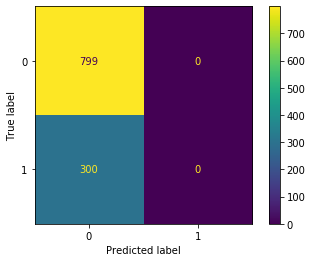

### exp-v2

- correcting label inbalance, scaling training data to two times the number of samples (repeating samples in training)
- (evaluation unchanged)

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_bert-base-uncased_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1099
INFO:__main__:  Batch size = 8
Evaluating: 100%|██████████| 138/138 [00:13<00:00, 10.33it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.7952684258416742
INFO:__main__:  acc_and_f1 = 0.7237547693350566
INFO:__main__:  confmat = [[663 136]
 [ 89 211]]
INFO:__main__:  corr = 0.5109586984858279
INFO:__main__:  f1 = 0.652241112828439
INFO:__main__:  mcc = 0.5109586984858279
INFO:__main__:  pearson = 0.5109586984858279
INFO:__main__:  spearmanr = 0.5109586984858279
```

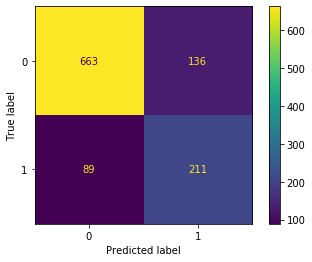

### exp-v3 (eval with all GS)

- use larger training dataset (all(?) categories from amazon)

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_bert-base-uncased_512_mwpd-all-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 4397
INFO:__main__:  Batch size = 8
Evaluating: 100%|██████████| 550/550 [00:54<00:00, 10.06it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.8098703661587446
INFO:__main__:  acc_and_f1 = 0.7764304958066044
INFO:__main__:  confmat = [[2902  297]
 [ 539  659]]
INFO:__main__:  corr = 0.4935263257774003
INFO:__main__:  f1 = 0.742990625454464
INFO:__main__:  mcc = 0.4935263257774003
INFO:__main__:  pearson = 0.4935263257774003
INFO:__main__:  spearmanr = 0.49352632577740024
```

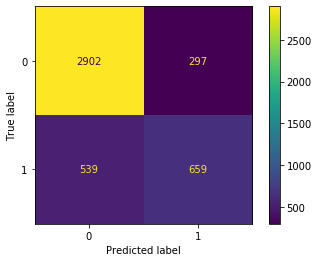

### exp-v3 (eval with on computer)

- train on all categories
- evaluation on exp-v1/v2 eval data (computer eval set)

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_bert-base-uncased_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1099
INFO:__main__:  Batch size = 8
Evaluating: 100%|██████████| 138/138 [00:13<00:00, 10.18it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.8034576888080073
INFO:__main__:  acc_and_f1 = 0.7229208973841361
INFO:__main__:  confmat = [[689 110]
 [106 194]]
INFO:__main__:  corr = 0.5069052809605072
INFO:__main__:  f1 = 0.6423841059602649
INFO:__main__:  mcc = 0.5069052809605072
INFO:__main__:  pearson = 0.5069052809605072
INFO:__main__:  spearmanr = 0.5069052809605071
```

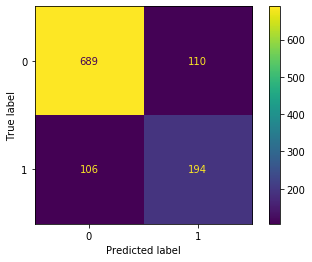

### exp-v4 (train on all, model distilroberta)

- train on all categories
- `distilroberta-base` model

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-all-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 4397
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 275/275 [00:25<00:00, 10.59it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9415510575392313
INFO:__main__:  acc_and_f1 = 0.9340799681755316
INFO:__main__:  class_rep = {'0': {'precision': 0.9622878692646134, 'recall': 0.9571741169115349, 'f1-score': 0.959724181162827, 'support': 3199}, '1': {'precision': 0.8872427983539095, 'recall': 0.8998330550918197, 'f1-score': 0.8934935764608372, 'support': 1198}, 'accuracy': 0.9415510575392313, 'macro avg': {'precision': 0.9247653338092614, 'recall': 0.9285035860016773, 'f1-score': 0.9266088788118321, 'support': 4397}, 'weighted avg': {'precision': 0.9418412022300391, 'recall': 0.9415510575392313, 'f1-score': 0.9416790903206654, 'support': 4397}}
INFO:__main__:  confmat = [[3062  137]
 [ 120 1078]]
INFO:__main__:  corr = 0.8532607309526627
INFO:__main__:  f1 = 0.9266088788118321
INFO:__main__:  mcc = 0.8532607309526626
INFO:__main__:  pearson = 0.853260730952663
INFO:__main__:  spearmanr = 0.8532607309526626

# check again
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-all-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 4397
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 275/275 [00:25<00:00, 10.59it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9415510575392313
INFO:__main__:  acc_and_f1 = 0.9340799681755316
INFO:__main__:  class_rep = {'0': {'precision': 0.9622878692646134, 'recall': 0.9571741169115349, 'f1-score': 0.959724181162827, 'support': 3199}, '1': {'precision': 0.8872427983539095, 'recall': 0.8998330550918197, 'f1-score': 0.8934935764608372, 'support': 1198}, 'accuracy': 0.9415510575392313, 'macro avg': {'precision': 0.9247653338092614, 'recall': 0.9285035860016773, 'f1-score': 0.9266088788118321, 'support': 4397}, 'weighted avg': {'precision': 0.9418412022300391, 'recall': 0.9415510575392313, 'f1-score': 0.9416790903206654, 'support': 4397}}
INFO:__main__:  confmat = [[3062  137]
 [ 120 1078]]
INFO:__main__:  corr = 0.8532607309526627
INFO:__main__:  f1 = 0.9266088788118321
INFO:__main__:  mcc = 0.8532607309526626
INFO:__main__:  pearson = 0.853260730952663
INFO:__main__:  spearmanr = 0.8532607309526626
```

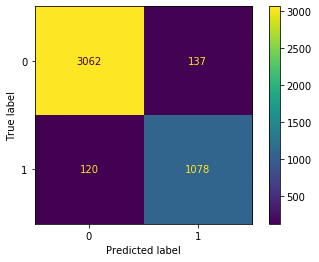

### exp-v4 (train on all, model distilroberta, eval on computer (official dev set))

- train on all categories
- `distilroberta-base` model
- eval on computer

```python
INFO:__main__:Saving features into cached file data/cache/cached_dev_distilroberta-base_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1099
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:06<00:00, 10.56it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9535941765241128
INFO:__main__:  acc_and_f1 = 0.9354680769168375
INFO:__main__:  class_rep = {'0': {'precision': 0.9782608695652174, 'recall': 0.9574468085106383, 'f1-score': 0.967741935483871, 'support': 799}, '1': {'precision': 0.8927444794952681, 'recall': 0.9433333333333334, 'f1-score': 0.9173419773095624, 'support': 300}, 'accuracy': 0.9535941765241128, 'macro avg': {'precision': 0.9355026745302428, 'recall': 0.9503900709219859, 'f1-score': 0.9425419563967167, 'support': 1099}, 'weighted avg': {'precision': 0.9549169960247399, 'recall': 0.9535941765241128, 'f1-score': 0.9539839851178178, 'support': 1099}}
INFO:__main__:  confmat = [[765  34]
 [ 17 283]]
INFO:__main__:  corr = 0.885767645533275
INFO:__main__:  f1 = 0.9173419773095624
INFO:__main__:  mcc = 0.8857676455332754
INFO:__main__:  pearson = 0.8857676455332747
INFO:__main__:  spearmanr = 0.8857676455332754
```

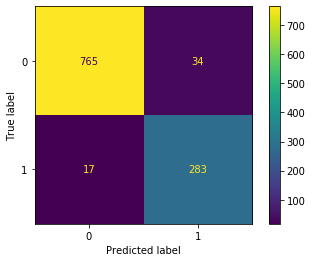

### exp-v4r (train on all, model distilroberta)

- train on all categories
- `distilroberta-base` model
- eval on all GS

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-all-r
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 4398
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 275/275 [00:25<00:00, 10.64it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9495225102319236
INFO:__main__:  acc_and_f1 = 0.9429920042428863
INFO:__main__:  confmat = [[3085  115]
 [ 107 1091]]
INFO:__main__:  corr = 0.8729326786452138
INFO:__main__:  f1 = 0.9364614982538491
INFO:__main__:  mcc = 0.8729326786452142
INFO:__main__:  mse = 0.04300735
INFO:__main__:  pearson = 0.8729326786452135
INFO:__main__:  r2 = 0.7782539181376227
INFO:__main__:  spearmanr = 0.8729326786452142
```

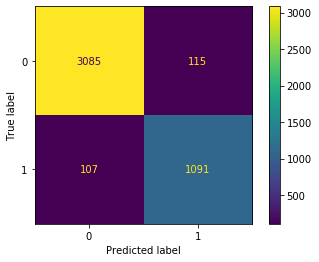

### exp-v4r (train on all, model distilroberta, eval on computer (official dev set))

- train on all categories
- `distilroberta-base` model
- eval on computer

```python
INFO:__main__:Saving features into cached file data/cache/cached_dev_distilroberta-base_512_mwpd-r
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:06<00:00, 10.61it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9672727272727273
INFO:__main__:  acc_and_f1 = 0.9631387053385388
INFO:__main__:  confmat = [[779  21]
 [ 15 285]]
INFO:__main__:  corr = 0.9180981405510587
INFO:__main__:  f1 = 0.9590046834043504
INFO:__main__:  mcc = 0.9180981405510584
INFO:__main__:  mse = 0.028282737
INFO:__main__:  pearson = 0.9180981405510587
INFO:__main__:  r2 = 0.8606490757621997
INFO:__main__:  spearmanr = 0.9180981405510585
```

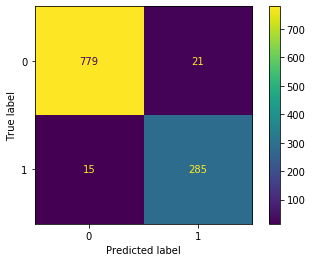

---

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp5)  # !!!!
#kwargs.update(kwargs_exp4r)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
kwargs["task_name"] = "mwpd-b"  # "mwpd-all-b"
kwargs["do_train"] = False
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v5 (all) | DistilBert Binary | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v5 (train on all/eval on computer, model distilbert)

- train on all & eval on computer
- `distilbert-base-cased` model
- text: title + description + specTable

```python
INFO:__main__:Saving features into cached file data/cache/cached_dev_distilbert-base-cased_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:13<00:00,  5.09it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9272727272727272
INFO:__main__:  acc_and_f1 = 0.9017168589924007
INFO:__main__:  class_rep = {'0': {'precision': 0.9774535809018567, 'recall': 0.92125, 'f1-score': 0.9485199485199486, 'support': 800}, '1': {'precision': 0.8179190751445087, 'recall': 0.9433333333333334, 'f1-score': 0.8761609907120743, 'support': 300}, 'accuracy': 0.9272727272727272, 'macro avg': {'precision': 0.8976863280231827, 'recall': 0.9322916666666667, 'f1-score': 0.9123404696160115, 'support': 1100}, 'weighted avg': {'precision': 0.9339441702407618, 'recall': 0.9272727272727272, 'f1-score': 0.9287856872996192, 'support': 1100}}
INFO:__main__:  confmat = [[737  63]
 [ 17 283]]
INFO:__main__:  corr = 0.8292562584670395
INFO:__main__:  f1 = 0.8761609907120743
INFO:__main__:  mcc = 0.8292562584670395
INFO:__main__:  pearson = 0.8292562584670395
INFO:__main__:  spearmanr = 0.8292562584670395
```

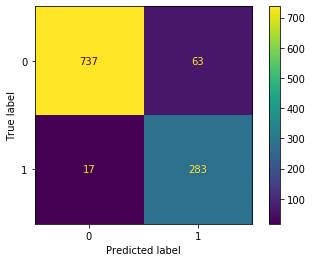

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v6 (title+desc+spec) | DistilRoBerta Binary | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v6 (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: title + description + specTable

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:12<00:00,  5.37it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9518181818181818
INFO:__main__:  acc_and_f1 = 0.9329593340209223
INFO:__main__:  class_rep = {'0': {'precision': 0.9770114942528736, 'recall': 0.95625, 'f1-score': 0.9665192672141504, 'support': 800}, '1': {'precision': 0.889589905362776, 'recall': 0.94, 'f1-score': 0.9141004862236628, 'support': 300}, 'accuracy': 0.9518181818181818, 'macro avg': {'precision': 0.9333006998078248, 'recall': 0.948125, 'f1-score': 0.9403098767189066, 'support': 1100}, 'weighted avg': {'precision': 0.9531692427373926, 'recall': 0.9518181818181818, 'f1-score': 0.9522232360349264, 'support': 1100}}
INFO:__main__:  confmat = [[765  35]
 [ 18 282]]
INFO:__main__:  corr = 0.8813010293909374
INFO:__main__:  f1 = 0.9141004862236628
INFO:__main__:  mcc = 0.8813010293909375
INFO:__main__:  pearson = 0.8813010293909371
INFO:__main__:  spearmanr = 0.8813010293909375
```

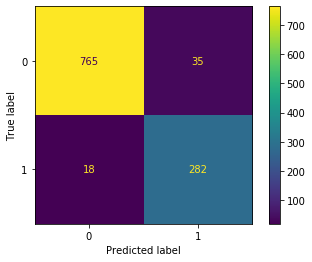

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!
kwargs.update(kwargs_exp6_title)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v6 (title) | DistilRoBerta Binary | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v6title (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: title

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-title-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:14<00:00,  4.91it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9545454545454546
INFO:__main__:  acc_and_f1 = 0.9492548447318416
INFO:__main__:  class_rep = {'0': {'precision': 0.9820051413881749, 'recall': 0.955, 'f1-score': 0.9683143219264893, 'support': 800}, '1': {'precision': 0.8881987577639752, 'recall': 0.9533333333333334, 'f1-score': 0.9196141479099679, 'support': 300}, 'accuracy': 0.9545454545454546, 'macro avg': {'precision': 0.9351019495760751, 'recall': 0.9541666666666666, 'f1-score': 0.9439642349182286, 'support': 1100}, 'weighted avg': {'precision': 0.9564215822179385, 'recall': 0.9545454545454546, 'f1-score': 0.9550324562856196, 'support': 1100}}
INFO:__main__:  confmat = [[764  36]
 [ 14 286]]
INFO:__main__:  corr = 0.8890642318733424
INFO:__main__:  f1 = 0.9439642349182286
INFO:__main__:  mcc = 0.8890642318733424
INFO:__main__:  pearson = 0.8890642318733422
INFO:__main__:  spearmanr = 0.8890642318733425
```

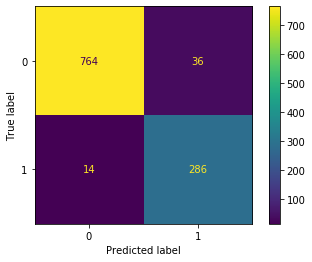

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!
kwargs.update(kwargs_exp6_desc)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v6 (desc) | DistilRoBerta Binary | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v6desc (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: description

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-desc-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 906
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 57/57 [00:11<00:00,  4.89it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.8631346578366446
INFO:__main__:  acc_and_f1 = 0.8324670854547889
INFO:__main__:  class_rep = {'0': {'precision': 0.9030898876404494, 'recall': 0.9212034383954155, 'f1-score': 0.9120567375886525, 'support': 698}, '1': {'precision': 0.7164948453608248, 'recall': 0.6682692307692307, 'f1-score': 0.6915422885572139, 'support': 208}, 'accuracy': 0.8631346578366446, 'macro avg': {'precision': 0.809792366500637, 'recall': 0.7947363345823231, 'f1-score': 0.8017995130729332, 'support': 906}, 'weighted avg': {'precision': 0.8602512907374009, 'recall': 0.8631346578366446, 'f1-score': 0.8614309038154304, 'support': 906}}
INFO:__main__:  confmat = [[643  55]
 [ 69 139]]
INFO:__main__:  corr = 0.6043411837165542
INFO:__main__:  f1 = 0.8017995130729332
INFO:__main__:  mcc = 0.604341183716554
INFO:__main__:  pearson = 0.6043411837165542
INFO:__main__:  spearmanr = 0.6043411837165541
```

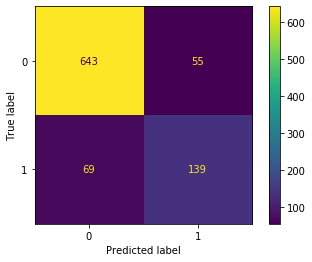

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!
kwargs.update(kwargs_exp6_spec)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v6 (spec) | DistilRoBerta Binary | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v6spec (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: specTable

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-spec-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 244
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9139344262295082
INFO:__main__:  acc_and_f1 = 0.8949498327560119
INFO:__main__:  class_rep = {'0': {'precision': 0.9572192513368984, 'recall': 0.9322916666666666, 'f1-score': 0.9445910290237467, 'support': 192}, '1': {'precision': 0.7719298245614035, 'recall': 0.8461538461538461, 'f1-score': 0.8073394495412844, 'support': 52}, 'accuracy': 0.9139344262295082, 'macro avg': {'precision': 0.864574537949151, 'recall': 0.8892227564102564, 'f1-score': 0.8759652392825156, 'support': 244}, 'weighted avg': {'precision': 0.9177313407126128, 'recall': 0.9139344262295082, 'f1-score': 0.9153406924127301, 'support': 244}}
INFO:__main__:  confmat = [[179  13]
 [  8  44]]
INFO:__main__:  corr = 0.7533942037939081
INFO:__main__:  f1 = 0.8759652392825156
INFO:__main__:  mcc = 0.753394203793908
INFO:__main__:  pearson = 0.7533942037939081
INFO:__main__:  spearmanr = 0.7533942037939081
```

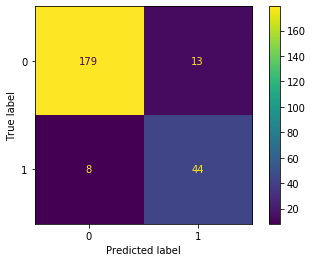

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!
kwargs.update(kwargs_exp7_combi_dts)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v7 (desc+title+spec) | DistilRoBerta Binary | SeqLen 512 | 3 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v7dts (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: description + title + specTable

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-dts-combi-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:11<00:00,  5.97it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9454545454545454
INFO:__main__:  acc_and_f1 = 0.9387031465286956
INFO:__main__:  class_rep = {'0': {'precision': 0.9683544303797469, 'recall': 0.95625, 'f1-score': 0.9622641509433963, 'support': 800}, '1': {'precision': 0.8870967741935484, 'recall': 0.9166666666666666, 'f1-score': 0.9016393442622951, 'support': 300}, 'accuracy': 0.9454545454545454, 'macro avg': {'precision': 0.9277256022866476, 'recall': 0.9364583333333334, 'f1-score': 0.9319517476028457, 'support': 1100}, 'weighted avg': {'precision': 0.9461932514198745, 'recall': 0.9454545454545454, 'f1-score': 0.9457301127576414, 'support': 1100}}
INFO:__main__:  confmat = [[765  35]
 [ 25 275]]
INFO:__main__:  corr = 0.8641398116000125
INFO:__main__:  f1 = 0.9319517476028457
INFO:__main__:  mcc = 0.8641398116000129
INFO:__main__:  pearson = 0.8641398116000123
INFO:__main__:  spearmanr = 0.8641398116000129
```

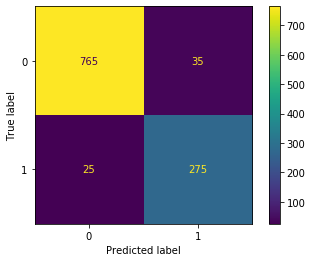

In [ ]:
kwargs = dict(**kwargs_expX_base)
kwargs.update(kwargs_exp3_2)
logger.info(f"Config: {kwargs}")

In [ ]:
# train
kwargs["do_train"] = True
kwargs["do_eval"] = False

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
# eval
kwargs["task_name"] = "mwpd-b"  # "mwpd-all-b"
kwargs["do_train"] = False
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v3-2 (train on amazon all, eval on computer, title+desc+spec) | DistilRoBerta Binary | SeqLen 512 | 15 Epochs - finished'
! echo "{results2}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v3-15epochs (train on all, model distilroberta, eval on computer (official dev set))

- train on all categories
- `distilroberta-base` model
- eval on computer
- 15 epochs

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:06<00:00, 10.82it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9772727272727273
INFO:__main__:  acc_and_f1 = 0.9676279602750191
INFO:__main__:  class_rep = {'0': {'precision': 0.9813664596273292, 'recall': 0.9875, 'f1-score': 0.9844236760124611, 'support': 800}, '1': {'precision': 0.9661016949152542, 'recall': 0.95, 'f1-score': 0.957983193277311, 'support': 300}, 'accuracy': 0.9772727272727273, 'macro avg': {'precision': 0.9737340772712917, 'recall': 0.96875, 'f1-score': 0.971203434644886, 'support': 1100}, 'weighted avg': {'precision': 0.9772033419785814, 'recall': 0.9772727272727273, 'f1-score': 0.977212635266511, 'support': 1100}}
INFO:__main__:  confmat = [[790  10]
 [ 15 285]]
INFO:__main__:  corr = 0.9424708986932552
INFO:__main__:  f1 = 0.957983193277311
INFO:__main__:  mcc = 0.9424708986932551
INFO:__main__:  mse = 0.022727272727272728
INFO:__main__:  pearson = 0.9424708986932552
INFO:__main__:  r2 = 0.8841983366670176
INFO:__main__:  spearmanr = 0.9424708986932552
```

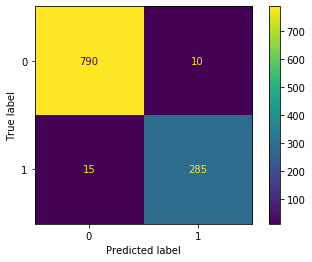

In [ ]:
kwargs = dict(**kwargs_expX_base)
kwargs.update(kwargs_exp3r_2)
logger.info(f"Config: {kwargs}")

In [ ]:
# train
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
# eval
kwargs["task_name"] = "mwpd-r"  # "mwpd-all-r"
kwargs["do_train"] = False
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

#kwargs["device"] = torch.device("cpu")
#kwargs["n_gpu"] = 0

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v3r-2 (train on amazon all, eval on computer, title+desc+spec) | DistilRoBerta Regression | SeqLen 512 | 15 Epochs - finished'
! echo "{results2}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v3r-15epochs (train on all, model distilroberta, eval on computer (official dev set), regression)

- train on all categories
- `distilroberta-base` model
- eval on computer
- 15 epochs
- regression output (1 output)

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-r
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:06<00:00, 10.45it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9727272727272728
INFO:__main__:  acc_and_f1 = 0.9691761363636364
INFO:__main__:  class_rep = {'0': {'precision': 0.98125, 'recall': 0.98125, 'f1-score': 0.98125, 'support': 800}, '1': {'precision': 0.95, 'recall': 0.95, 'f1-score': 0.9500000000000001, 'support': 300}, 'accuracy': 0.9727272727272728, 'macro avg': {'precision': 0.965625, 'recall': 0.965625, 'f1-score': 0.965625, 'support': 1100}, 'weighted avg': {'precision': 0.9727272727272728, 'recall': 0.9727272727272728, 'f1-score': 0.9727272727272728, 'support': 1100}}
INFO:__main__:  confmat = [[785  15]
 [ 15 285]]
INFO:__main__:  corr = 0.9312499999999999
INFO:__main__:  f1 = 0.965625
INFO:__main__:  mcc = 0.93125
INFO:__main__:  mse = 0.024024362
INFO:__main__:  pearson = 0.9312499999999997
INFO:__main__:  r2 = 0.8820936538878217
INFO:__main__:  spearmanr = 0.9312500000000001
```

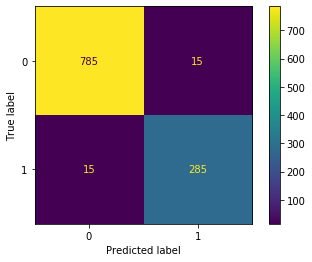

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!
kwargs.update(kwargs_exp6_2)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v6-2 (title+desc+spec) | DistilRoBerta Binary | SeqLen 512 | 15 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

### exp-v6_2-15epochs (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: title + description + specTable
- 15 Epochs

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-b
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:06<00:00, 10.46it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9727272727272728
INFO:__main__:  acc_and_f1 = 0.9616111611161116
INFO:__main__:  class_rep = {'0': {'precision': 0.9848866498740554, 'recall': 0.9775, 'f1-score': 0.9811794228356336, 'support': 800}, '1': {'precision': 0.9411764705882353, 'recall': 0.96, 'f1-score': 0.9504950495049505, 'support': 300}, 'accuracy': 0.9727272727272728, 'macro avg': {'precision': 0.9630315602311453, 'recall': 0.96875, 'f1-score': 0.965837236170292, 'support': 1100}, 'weighted avg': {'precision': 0.9729656918870134, 'recall': 0.9727272727272728, 'f1-score': 0.9728109573818109, 'support': 1100}}
INFO:__main__:  confmat = [[782  18]
 [ 12 288]]
INFO:__main__:  corr = 0.9317640127378808
INFO:__main__:  f1 = 0.9504950495049505
INFO:__main__:  mcc = 0.9317640127378807
INFO:__main__:  mse = 0.02727272727272727
INFO:__main__:  pearson = 0.9317640127378808
INFO:__main__:  r2 = 0.8641774089988641
INFO:__main__:  spearmanr = 0.9317640127378808
```

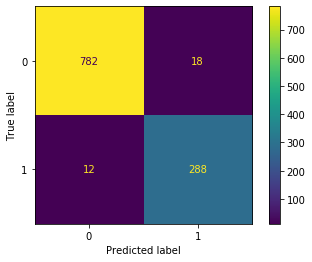

In [ ]:
kwargs = dict(**kwargs_expX_base)

kwargs.update(kwargs_exp6_base)  # !!!!
kwargs.update(kwargs_exp6_2)  # !!!!
kwargs.update(kwargs_exp6r_2)  # !!!!

logger.info(f"Config: {kwargs}")

In [ ]:
kwargs["do_train"] = True
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
kwargs["do_train"] = False
kwargs["do_eval"] = True

kwargs["device"] = torch.device("cuda:1")
kwargs["n_gpu"] = 1

set_seed(kwargs["seed"])
results = run(kwargs)

In [ ]:
# s = io.StringIO(); print(results, file=s); results2 = s.getvalue()
! dbot-message -c ~/.dbot.mwpd.conf 'MWPD: exp-v6r-2 (title+desc+spec) | DistilRoBerta Regression | SeqLen 512 | 15 Epochs - finished'
! echo "{results}" | dbot-message -c ~/.dbot.mwpd.conf "-" --type

## exp-v6r_2-15epochs (train/eval on computer, model distilroberta)

- train & eval on computer
- `distilroberta-base` model
- text: title + description + specTable
- 15 Epochs + regression

```python
INFO:__main__:Loading features from cached file data/cache/cached_dev_distilroberta-base_512_mwpd-r
INFO:__main__:***** Running evaluation  *****
INFO:__main__:  Num examples = 1100
INFO:__main__:  Batch size = 16
Evaluating: 100%|██████████| 69/69 [00:06<00:00, 10.75it/s]
INFO:__main__:***** Eval results  *****
INFO:__main__:  acc = 0.9754545454545455
INFO:__main__:  acc_and_f1 = 0.9724009141771772
INFO:__main__:  class_rep = {'0': {'precision': 0.988621997471555, 'recall': 0.9775, 'f1-score': 0.9830295411690761, 'support': 800}, '1': {'precision': 0.941747572815534, 'recall': 0.97, 'f1-score': 0.9556650246305418, 'support': 300}, 'accuracy': 0.9754545454545455, 'macro avg': {'precision': 0.9651847851435444, 'recall': 0.97375, 'f1-score': 0.969347282899809, 'support': 1100}, 'weighted avg': {'precision': 0.9758380634744585, 'recall': 0.9754545454545455, 'f1-score': 0.9755664912040214, 'support': 1100}}
INFO:__main__:  confmat = [[782  18]
 [  9 291]]
INFO:__main__:  corr = 0.9388957172375517
INFO:__main__:  f1 = 0.969347282899809
INFO:__main__:  mcc = 0.9388957172375517
INFO:__main__:  mse = 0.023099445
INFO:__main__:  pearson = 0.9388957172375516
INFO:__main__:  r2 = 0.8919976135184438
INFO:__main__:  spearmanr = 0.9388957172375518
```

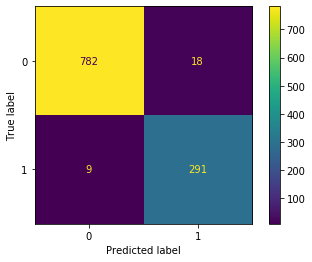

---

## All results

- seq-len: 512

```
experiment         acc    f1     mse    model                  epochs  train data  val data  composition

-- initial, label balancing, more data
exp-v1             72.70   0.00         bert-base-uncased      3       comp-train  comp-val  -- label inbalance
exp-v2             79.53  65.22         bert-base-uncased      3       comp-train  comp-val  -- label balanced
exp-v3             80.35  64.24         bert-base-uncased      3       all         comp-val  title-desc-spec
exp-v3             80.99  74.30         bert-base-uncased      3       all         all-val   title-desc-spec

-- test distil* models
exp-v4             95.36  91.73         distilroberta-base     3       all         comp-val  title-desc-spec
exp-v4r            96.73  95.90  02.83  distilroberta-base     3       all         comp-val  title-desc-spec
exp-v4             94.16  92.66         distilroberta-base     3       all         all-val   title-desc-spec
exp-v4r            94.95  93.65  04.30  distilroberta-base     3       all         all-val   title-desc-spec
exp-v5             92.73  87.62         distilbert-base-cased  3       all         comp-val  title-desc-spec

-- test different combinations
exp-v6             95.18  91.41         distilroberta-base     3       comp-train  comp-val  title-desc-spec
exp-v6title        95.45  94.40         distilroberta-base     3       comp-train  comp-val  title
exp-v6desc         86.31  80.18         distilroberta-base     3       comp-train  comp-val  desc
exp-v6spec         91.39  87.60         distilroberta-base     3       comp-train  comp-val  spec
exp-v7dts          94.55  93.20         distilroberta-base     3       comp-train  comp-val  desc-title-spec

-- test more epochs
exp-v6_2-15epochs   97.27  95.05  02.73  distilroberta-base    15       comp-train  comp-val  title-desc-spec
exp-v6r_2-15epochs  97.55  96.93  02.31  distilroberta-base    15       comp-train  comp-val  title-desc-spec
exp-v3-15epochs     97.73  95.80         distilroberta-base    15       all         comp-val  title-desc-spec
exp-v3r-15epochs    97.27  96.56  02.40  distilroberta-base    15       all         comp-val  title-desc-spec
```

### Label-1 F1

```
experiment          f1 ('1')  model          epochs  train  eval

exp-v4              91.73     distilroberta   3      all    comp
exp-v5              87.62     distilbert      3      all    comp
exp-v6              91.41     distilroberta   3      comp   comp

exp-v6_2-15epochs   95.05     distilroberta  15      comp   comp
exp-v6r_2-15epochs  95.57     distilroberta  15      comp   comp
exp-v3-15epochs     95.80     distilroberta  15      all    comp
exp-v3r-15epochs    95.00     distilroberta  15      all    comp
```